In [1]:
from main import Point_Process_Model

/home/imanring/PointProcess/Cox_Hawkes/cox_hawkes/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
A = ((3,15.5),(4,16.5))
model_name = 'hawkes'
model = Point_Process_Model('data/spt_data.csv',A,model=model_name,spatial_cov='data/spatial_cov.csv')

In [21]:
import pickle
pre_run = False
if pre_run:
    with open(f'output/{model_name}/output.pkl', 'rb') as f:
        output = pickle.load(f)
    model.mcmc = output['mcmc']
    model.mcmc_samples = output['samples']
else:
    model.run_mcmc()

sample: 100%|████████████████████████████| 1500/1500 [15:36<00:00,  1.60it/s, 15 steps of size 2.47e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_0      0.17      0.11      0.18      0.01      0.36    764.00      1.00
     alpha      0.89      0.01      0.89      0.86      0.91   1685.70      1.00
      beta      1.21      0.05      1.21      1.14      1.30   1138.35      1.00
  sigmax_2      0.00      0.00      0.00      0.00      0.00    744.92      1.00
      w[0]      1.81      0.11      1.81      1.63      1.98    646.53      1.00
      w[1]     -0.18      0.07     -0.18     -0.31     -0.07    610.86      1.00
      w[2]      0.22      0.05      0.22      0.14      0.31   1049.61      1.00
      w[3]     -0.75      0.07     -0.75     -0.87     -0.64   1072.38      1.00
      w[4]      0.24      0.07      0.24      0.12      0.35   1036.88      1.00
      w[5]      0.29      0.07      0.29      0.19      0.41    909.63      1.00
      w[6]      0.34      0.09      0.34      0.19      0.48    742.62      1.00
      w[7]     -0.04      0

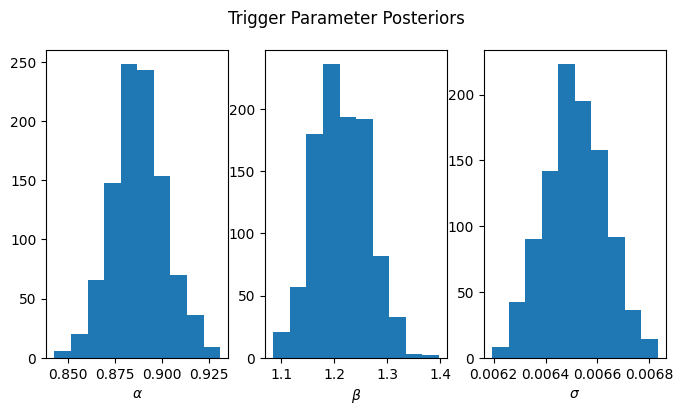

In [22]:
model.plot_trigger_posterior(f'output/{model_name}/trig_post.png')

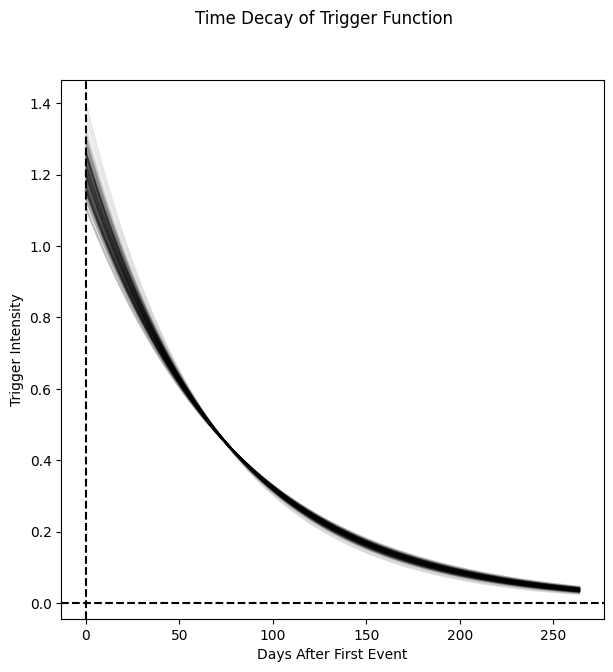

Mean trigger time: 75.4 days


In [23]:
model.plot_trigger_time_decay(f'output/{model_name}/trig_post_time_decay.png')

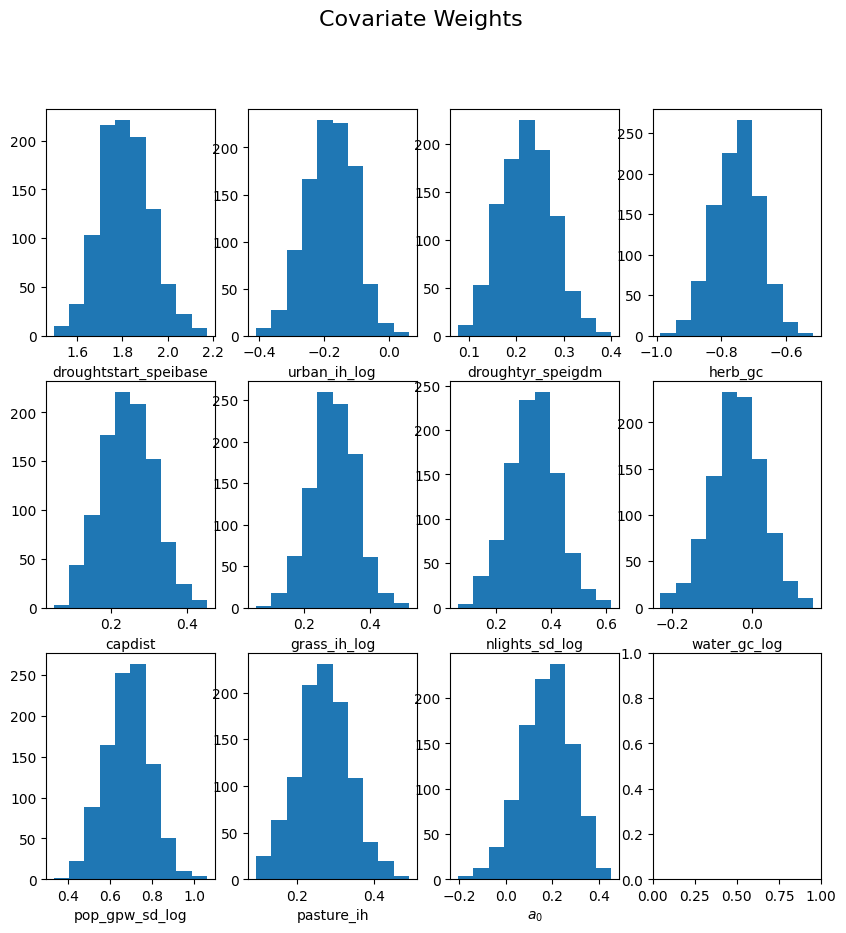

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
droughtstart_speibase,1.814285,0.111428,16.282158,0.000000e+00,1.612476,2.046229
urban_ih_log,-0.180063,0.074189,-2.427100,1.522006e-02,-0.326383,-0.040632
droughtyr_speigdm,0.223275,0.054434,4.101725,4.100811e-05,0.120022,0.334757
herb_gc,-0.751900,0.070781,-10.622947,0.000000e+00,-0.891772,-0.615827
capdist,0.243365,0.067708,3.594341,3.252138e-04,0.117079,0.376596
grass_ih_log,0.289562,0.068338,4.237206,2.263180e-05,0.155961,0.425149
nlights_sd_log,0.335607,0.088992,3.771219,1.624522e-04,0.163079,0.511740
water_gc_log,-0.037397,0.065382,-0.571980,5.673358e-01,-0.173756,0.091434
pop_gpw_sd_log,0.686740,0.106139,6.470218,9.786139e-11,0.481005,0.897275
pasture_ih,0.268739,0.068603,3.917289,8.955039e-05,0.132128,0.410077


In [24]:
model.cov_weight_post_summary(plot_file=f'output/{model_name}/cov_post_hist.png',
                              summary_file=f'output/{model_name}/cov_par_summary.csv')

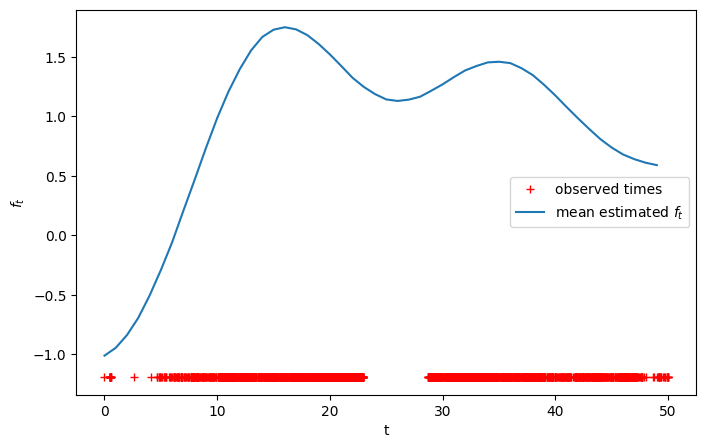

In [17]:
model.plot_temporal_background(f'output/{model_name}/temporal_gp_post_mean.png')

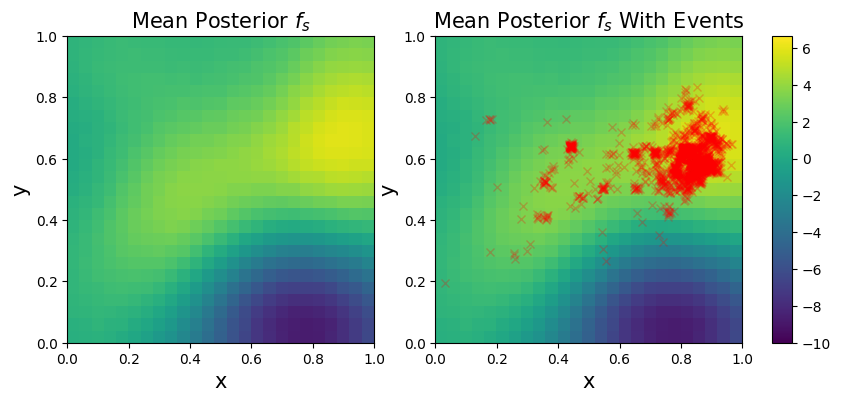

In [18]:
model.plot_spatial_background(f'output/{model_name}/spatial_gp_post_mean.png')

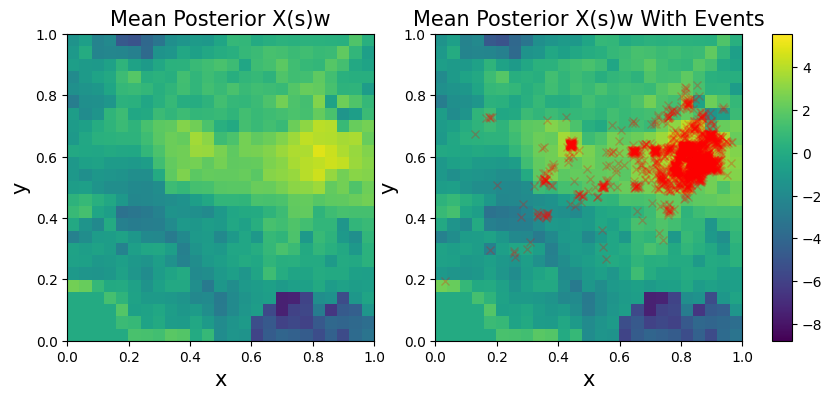

In [25]:
model.plot_spatial_background(f'output/{model_name}/spatial_gp_cov_post_mean.png',include_cov=True)